In [2]:
!pip install pytorch_lightning
!pip install pytorch-lifestream

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [9]:
#Change to your data folder
%cd /content/drive/MyDrive/content/drive/MyDrive/ML_final_project

/content/drive/MyDrive/content/drive/MyDrive/ML_final_project


In [10]:
#Creating iterable datasets from .parquet files
from ptls.data_load.datasets import ParquetDataset, ParquetFiles

iterable_train = ParquetDataset(ParquetFiles('train.parquet'))
next(iter(iterable_train))

{'user_id': '44c6769d14ac44c8b2325a5ff4d98470',
 'cat_id': tensor([44,  1, 44,  ...,  1,  1,  1], dtype=torch.int32),
 'event_time': tensor([1611145856, 1611984311, 1612090463,  ..., 1623660249, 1623678888,
         1623762102])}

In [11]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter, FeatureFilter

map_processed_train = MemoryMapDataset(
    data=iterable_train,
    i_filters=[
        SeqLenFilter(min_seq_len=25),
    ],
)

In [12]:
map_processed_train[0]

{'user_id': '44c6769d14ac44c8b2325a5ff4d98470',
 'cat_id': tensor([44,  1, 44,  ...,  1,  1,  1], dtype=torch.int32),
 'event_time': tensor([1611145856, 1611984311, 1612090463,  ..., 1623660249, 1623678888,
         1623762102])}

#Creating model

In [13]:
import torch
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={},
    embeddings={
        'event_time': {'in': 800, 'out': 16},
        'cat_id': {'in': 410, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=800,
    type='gru',
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

#Creating dataloaders

In [14]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule

train_dl = PtlsDataModule(
    train_data=ColesDataset(
        map_processed_train,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=200,
        ),
    ),
    train_num_workers=2,
    train_batch_size=64,
)

#Training procedure

In [15]:
import torch
import pytorch_lightning as pl

import logging

trainer = pl.Trainer(
    max_epochs=150,
    gpus=1 if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [16]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


logger.version = 0


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 2.0 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.087     Total estimated model params size (MB)


{'loss': tensor(52.0273), 'seq_len': tensor(117.6914)}
CPU times: user 3h 1min 41s, sys: 1min 25s, total: 3h 3min 7s
Wall time: 3h 12min 14s


In [17]:
torch.save(seq_encoder.state_dict(), "coles-emb-clickstream.pt")

#Creating embeddings

In [18]:
from ptls.data_load.datasets import inference_data_loader

iterable_test = ParquetDataset(ParquetFiles('test.parquet'))

train_dl = inference_data_loader(list(iter(iterable_train)), num_workers=0, batch_size=64)

train_embeds = torch.vstack(trainer.predict(model, train_dl, ))


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [19]:
train_embeds = torch.vstack(trainer.predict(model, train_dl, ))

test_dl = inference_data_loader(list(iter(iterable_test)), num_workers=0, batch_size=64)
test_embeds = torch.vstack(trainer.predict(model, test_dl))

train_embeds.shape, test_embeds.shape

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(torch.Size([15715, 800]), torch.Size([3908, 800]))

#Creating pandas df-s with embeddings and target

In [21]:
import pandas as pd
df_target = pd.read_csv('target_dataset_matched.csv')
df_target.rename(columns={'rtk':'user_id'},inplace=True)
df_target = df_target.set_index('user_id')
df_target.rename(columns={"higher_education": "target"}, inplace=True)

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['user_id'] = [x['user_id'] for x in iter(iterable_train)]
train_df = train_df.merge(df_target, how='left', on='user_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['user_id'] = [x['user_id'] for x in iter(iterable_test)]
test_df = test_df.merge(df_target, how='left', on='user_id')

print(train_df.shape, test_df.shape)

(15715, 802) (3908, 802)


In [22]:
train_df.head()

,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,...,embed_792,embed_793,embed_794,embed_795,embed_796,embed_797,embed_798,embed_799,user_id,target
0,0.999581,0.999927,-0.286775,-0.001530,0.100172,0.999996,-0.576632,0.212463,-0.369466,0.056238,...,0.586036,-0.160652,-0.517759,-0.998498,0.137599,-0.169210,-0.013057,0.990942,44c6769d14ac44c8b2325a5ff4d98470,NaN
1,1.000000,0.999983,-0.308377,0.305219,-0.004733,1.000000,-0.190570,-0.097774,0.458890,0.026820,...,0.189250,-0.028318,-0.122350,-0.999997,-0.154973,0.951301,0.349644,1.000000,6055e2a16e7f42ff81507a864a64434a,NaN
2,0.995233,0.999999,0.183809,0.062960,0.170753,0.999913,-0.248588,0.017811,0.215983,0.055552,...,0.108500,-0.118591,-0.094976,-0.919730,-0.252030,-0.131024,0.074389,1.000000,f74dd84cbeef41228988d30fb7f1f6c0,NaN
3,0.999977,0.999954,-0.106581,0.148248,0.051510,1.000000,-0.393568,0.027748,0.493191,-0.186794,...,0.422815,-0.107897,0.024104,-0.959465,0.178676,-0.278661,-0.027148,0.999999,2a1b1913f2104171bc198101ccfad023,NaN
4,1.000000,0.999986,0.106824,0.100652,0.021540,1.000000,-0.316949,-0.093824,0.805055,-0.062347,...,0.010349,-0.073432,-0.002625,-0.997213,-0.170893,-0.156715,-0.032868,1.000000,6a250b31483e483e97e05ed8ca971c18,1.0


In [23]:
#Dropping nan-s,that appears due to lack of target variables for some of the users
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [24]:
train_df.shape,test_df.shape

((5051, 802), (1303, 802))

In [25]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
x_train, y_train = train_df[embed_columns], train_df['target']
x_test, y_test = test_df[embed_columns], test_df['target']


In [26]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 15.2 MB/s eta 0:00:00


#Performing a downstream task, using catboost

In [27]:
from catboost import CatBoostClassifier, metrics
CatBoostModel = CatBoostClassifier(
iterations= 500,
learning_rate = 0.05,
use_best_model = True,
eval_metric ='AUC', 
loss_function='Logloss',
random_seed = 42,
logging_level = 'Silent',
depth = 5)

In [28]:
CatBoostModel.fit(
    x_train, y_train,
    eval_set=(x_test, y_test),
    plot=True
#     logging_level='Verbose',  # you can uncomment this for text output
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
CatBoostModel.get_best_score()

{'learn': {'Logloss': 0.27183286673100815},
 'validation': {'Logloss': 0.5787850853069487, 'AUC': 0.6293671967938279}}

In [30]:
y_pred = CatBoostModel.predict(x_test)
y_proba = CatBoostModel.predict_proba(x_test)

In [31]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

print(f'''accuracy: {CatBoostModel.score(x_test, y_test)} 
      f1: {f1_score(y_pred, y_test)}, 
      precision: {precision_score(y_pred, y_test)}
     roc auc : {roc_auc_score(y_test, y_proba[:,1])}''')

accuracy: 0.7152724481964697 
      f1: 0.8337068579112505, 
      precision: 0.9989258861439313
     roc auc : 0.6293671967938279


#Experiment with different size of embeddings

In [32]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

embed_sizes = [32,64,96,128,256,512]
auc_mean_list = np.zeros(len(embed_sizes))
auc_std_list = np.zeros(len(embed_sizes))

In [33]:
for i,embed_size in enumerate(embed_sizes):

  trx_encoder_params = dict(
      embeddings_noise=0.003,
      numeric_values={},
      embeddings={
          'event_time': {'in': 800, 'out': 16},
          'cat_id': {'in': 410, 'out': 16},
      },
  )

  seq_encoder = RnnSeqEncoder(
      trx_encoder=TrxEncoder(**trx_encoder_params),
      hidden_size=embed_size,
      type='gru',
  )

  model = CoLESModule(
      seq_encoder=seq_encoder,
      optimizer_partial=partial(torch.optim.Adam, lr=0.001),
      lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
  )

  train_dl = PtlsDataModule(
      train_data=ColesDataset(
          map_processed_train,
          splitter=SampleSlices(
              split_count=5,
              cnt_min=25,
              cnt_max=200,
          ),
      ),
      train_num_workers=2,
      train_batch_size=64,
  )


  trainer = pl.Trainer(
      max_epochs=15,
      gpus=1 if torch.cuda.is_available() else 0,
      enable_progress_bar=False,
  )

  print(f'logger.version = {trainer.logger.version}')
  trainer.fit(model, train_dl)
  print(trainer.logged_metrics)


  train_dl = inference_data_loader(list(iter(iterable_train)), num_workers=0, batch_size=64)

  train_embeds = torch.vstack(trainer.predict(model, train_dl, ))


  train_embeds = torch.vstack(trainer.predict(model, train_dl, ))

  test_dl = inference_data_loader(list(iter(iterable_test)), num_workers=0, batch_size=64)
  test_embeds = torch.vstack(trainer.predict(model, test_dl))


  df_target = pd.read_csv('target_dataset_matched.csv')
  df_target.rename(columns={'rtk':'user_id'},inplace=True)
  df_target = df_target.set_index('user_id')
  df_target.rename(columns={"higher_education": "target"}, inplace=True)

  train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
  train_df['user_id'] = [x['user_id'] for x in iter(iterable_train)]
  train_df = train_df.merge(df_target, how='left', on='user_id')

  test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
  test_df['user_id'] = [x['user_id'] for x in iter(iterable_test)]
  test_df = test_df.merge(df_target, how='left', on='user_id')

  train_df.dropna(inplace=True)
  test_df.dropna(inplace=True)

  embed_columns = [x for x in train_df.columns if x.startswith('embed')]
  x_train, y_train = train_df[embed_columns], train_df['target']
  x_test, y_test = test_df[embed_columns], test_df['target']

  clf = RandomForestClassifier(random_state=42,n_jobs=-1)
  score = cross_val_score(clf,x_train,y_train,scoring='roc_auc',n_jobs=-1)


  auc_mean_list[i] = np.mean(score)
  auc_std_list[i] = np.std(score)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 25.7 K
2 | _validation_metric | BatchRecallTopK | 0     
3 | _

logger.version = 1
{'loss': tensor(73.4025), 'seq_len': tensor(112.7486)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       

logger.version = 2
{'loss': tensor(59.3714), 'seq_len': tensor(112.0171)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       

logger.version = 3
{'loss': tensor(60.6569), 'seq_len': tensor(109.2971)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       

logger.version = 4
{'loss': tensor(63.0508), 'seq_len': tensor(110.9086)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       

logger.version = 5
{'loss': tensor(59.5405), 'seq_len': tensor(116.3886)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       

logger.version = 6
{'loss': tensor(62.6393), 'seq_len': tensor(113.1771)}


INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


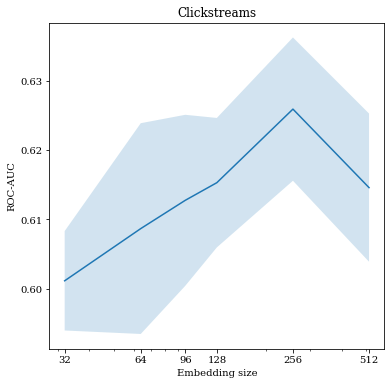

In [34]:
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(6,6))

plt.title('Clickstreams',fontfamily='serif')
plt.xlabel('Embedding size',fontfamily='serif')
plt.plot(embed_sizes,auc_mean_list)
plt.fill_between(embed_sizes,auc_mean_list-auc_std_list,
                 auc_mean_list+auc_std_list,alpha=0.2)
plt.ylabel('ROC-AUC',fontfamily='serif')
plt.xscale('log')
plt.xticks(embed_sizes,fontfamily='serif')
plt.yticks(fontfamily='serif')
fig.axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


plt.show()

In [35]:

auc_mean_list,auc_std_list

(array([0.60113226, 0.60868177, 0.61277091, 0.61532157, 0.62596119,
        0.61460546]),
 array([0.00718888, 0.01524186, 0.01236792, 0.00936228, 0.01036138,
        0.01071682]))